![image](resources/qcqh-lab-header.png)

This code is a Qiskit implementation, inspired by [Pennylane's first tutorial](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html).

# Objective 
We want to construct a NOT gate using a 3-parameters, parametrized quantum circuit by classical optimization of its parameters.

# Quantum circuit
In previous tutorial we have seen that qubits states are always initialized in the state $|0\rangle=\begin{bmatrix} 1 \\ 0\end{bmatrix}$.

Now we consider the following quantum gate :

$$U(\theta, \phi, \lambda) = \begin{bmatrix} \cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
            e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda)}\cos(\frac{\theta}{2})
     \end{bmatrix}$$

$U$ stands for unitary, which means that $U^{\dagger}U=\mathbb{I}$ ($\dagger$ is the complex conjugate). This gate is the most general *one qubit* quantum gate, from which you can derive all other *one qubit* canonical gates. For simplicity, we will write $U_3$ as it has three parameters.

# Protocole :
1. First, we will apply this gate to the initial state $|0\rangle$, such that the obtained new state is $|\psi\rangle=U_3|0\rangle$.
2. Second, we will measure the expectation value  $\langle\psi|\sigma_z|\psi\rangle$ along the axis Z, with the observable Pauli-Z operator :

$$\begin{split}\sigma_z =
\begin{bmatrix} 1 &  0 \\
                0 & -1
\end{bmatrix}\end{split}$$

# Solution
First, by replacing $|\psi\rangle$ in the expression $\langle\psi|\sigma_z|\psi\rangle$ we have :

$$\langle\psi|\sigma_z|\psi\rangle = \langle0|U_3^{\dagger}\sigma_zU_3|0\rangle$$

Then, by recalling that $\dagger$ is the complex conjugate, and with a bit of maths, we can show that the solution is :
$$\langle\psi|\sigma_z|\psi\rangle=cos^2(\theta/2)-sin^2(\theta/2)$$

---
Recall our objective is to perform a not gate, which means that we want the following:
- $U_3|0\rangle=|1\rangle$
- $U_3|1\rangle=|0\rangle$
---

Several things to note in that regard:
1. First, since we measure on the Z-basis, the solution only depends on the parameter $\theta$; hence, the two other parameters are not needed.
2. We can easily deduce the optimal parameter value by plotting some parameter values  :
     - For $\theta=0$ $\rarr$  $cos^2(\theta/2)-sin^2(\theta/2)=1$
     - For $\theta=\pi/2$ $\rarr$  $cos^2(\theta/2)-sin^2(\theta/2)=0$
     - For $\theta=\pi$ $\rarr$  $cos^2(\theta/2)-sin^2(\theta/2)=-1$
3. Remark that for $\theta=\pi$, assuming $\phi$ and $\lambda$ are zero, we will obtain exactly the Pauli-X gate :
$$U(\pi, 0, 0)=\begin{split}\sigma_x =
\begin{bmatrix} 0 &  1 \\
                1 & 0
\end{bmatrix}\end{split}$$
4. Trivially, the solution we hope the algorithm will find, is $\theta=\pi$ ! Because
by definition :
$$\sigma_x|0\rangle=|1\rangle=\begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

*NB : why do we get expectation values between 1 and -1 ?*
- We are evaluating the expectation value of the Z operator : $<\sigma_z>$.
- Notice that $\sigma_z|0\rangle=+|0\rangle$ and $\sigma_z|1\rangle=-|1\rangle$
- It means that 1 and -1 are eigenvalues associated with eigenvectors $|0\rangle$ and $|1\rangle$ respectively !

# Cost function
The role of a cost function is to attribute a cost proportionate to the error between the desired state and the actutal state. Since the solution we want must be the one associated with the minimum in our cost function, without realizing it, we just encoded our **cost function** in the **expectation value**!
- For $\theta=0$ we have $\langle\psi|\sigma_z|\psi\rangle=1$ (maximmum cost, worst solution)
- For $\theta=\pi$ we have $\langle\psi|\sigma_z|\psi\rangle=-1$ (minimum cost, optimal solution)


# Import libraries

In [1]:
# Libraries
from math import log
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import SPSA
from qiskit.quantum_info import Statevector



# Implementing the circuit

We have to create a circuit, that will take a `Parameter` object as argument of the `U` gate.

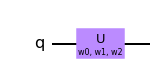

In [2]:
# Quantum circuit with parameters

def circuit(qc, W):        
    qc.u( W[0],  W[1],  W[2], 0) # Unitary gate with 3 paramters, applied to qubit 0
    return qc


qc = QuantumCircuit(1) # Create the circuit, with one qubit
nbParameter = 3
w_param = [Parameter(f'w{i}') for i in range(nbParameter)] # Create a list of Parameter objects
qc = circuit(qc, w_param)
qc.draw('mpl')

# State vector

The purpose of this tutorial is to illustrate how the quantum circuit relate
to the mathematics.

We will use the `statevector_simulator` that can compute the quantum circuit's mathematical state vector as gates are applied.
We use the `execute` function to run the circuit as in the previous tutorial.

*NB : You cannot access the vector state of a real quantum circuit*

Since we will have to perform this operation many times in the optimization process, we need
to create a function `get_statevector` :

In [22]:
def get_statevector(qc, w, param_w, backend):
    """
    Binds the parameters of a parametrized quantum circuit to their values and execute
    the circuit with the statevector simulator.
    """

    # Bind parameter values to the circuit
    params_dict = {p:v for (p,v) in zip(param_w, w)} # Create a dictionary of Parameter:value
    grounded_circ = qc.bind_parameters(params_dict) # Function to bind parameter to the circuit

    # Execute and get state vector
    result = execute(grounded_circ, backend).result() # Execute the circuit with given backend
    statevector = result.get_statevector() # Obtain the state vector of the circuit

    return statevector

# Example 
In the following box, we use the `get_statevector` function to display the state vector for some value of the parameters `w_param`:

In [28]:
# Backend simulator
sv_sim = Aer.get_backend('statevector_simulator')

W_init = [0.01, 0.1, 0.1] # [theta, phi, lambda]
psi_ket = get_statevector(qc, W_init, w_param, sv_sim)
psi_ket = psi_ket.reshape(2, 1)
print(psi_ket)


[[0.9999875+0.j        ]
 [0.004975 +0.00049917j]]


As you can see, since we put a very low value for the parameter $\theta$, the real part in the first dimension of $|\psi\rangle$ is very close to one. As expected $|\psi\rangle \sim |0\rangle$.

*NB: You can verify that the result would not change if you modified $\phi$ or $\lambda$*.

# Expectation value

Now it is time to implement the expectation value of the pauli-Z operator :

$$\begin{split}\sigma_z =
\begin{bmatrix} 1 &  0 \\
                0 & -1
\end{bmatrix}.\end{split}$$

We want to compute $\langle\psi|\sigma_z|\psi\rangle$ :

In [9]:
Z_matrix = np.array([[1, 0], [0, -1]]) # Pauli-Z operator
psi_bra = np.conj(psi_ket.T)
print('<psi| =', psi_bra)
print('---------------')
print('Z =')
print(Z_matrix)
print('---------------')
print('|psi> =')
print(psi_ket)
print('---------------')
excpectedValue = psi_bra@Z_matrix@psi_ket
print('<Z> =', np.real(excpectedValue)[0][0])

<psi| = [[0.9999875-0.j         0.004975 -0.00049917j]]
---------------
Z =
[[ 1  0]
 [ 0 -1]]
---------------
|psi> =
[[0.9999875+0.j        ]
 [0.004975 +0.00049917j]]
---------------
<Z> = 0.9999500004166653


Note how the expectation values is very close to $1$. This is exactly what we computed mathematically.

# Cost function

Now that we know how to compute the expected value, we can compute the cost function. We will create a function `cost_function` that will be used in the optimizer :

In [6]:
def cost_function(w, w_param, qc, backend):
    
    # Compute state vector
    statevectors = get_statevector(qc, w, w_param, backend)
    
    # Expectation value 
    psi = statevectors.reshape(2, 1)
    excpectedValue = (np.conj(psi.T)@Z_matrix@psi)[0]
        
    return np.real(excpectedValue[0])


# Get handles on the statevector simulator
sv_sim = Aer.get_backend('statevector_simulator')

# Compute cost
initial_weights = np.array([0.011, 0.012, 0.1])
result = cost_function(initial_weights, w_param, qc, sv_sim)
print(result)

0.9999395006100393


# Optimizer

Now that everything is defined, we will use a classical optimizer to find the parameter that will minimize the cost function. 

1. Traditionally, in machine learning, the optimizer needs a `callback` function that will give helpful information during the optimization process :


In [7]:
def optimizer_callback(nb_fct_eval, params, fct_value, stepsize, step_accepted, train_history):
    """
    Callback used to record the weight parameters at each epoch and to print
    the progress of the loss. 
    
    :param nb_fct_eval: The number of function evaluations
    :param params: The parameters
    :param fct_value: The function value
    :param stepsize: The stepsize
    :param step_accepted: Whether the step was accepted
    :param train_history: A list to record the training parameters 
    """
    train_history.append(params)
    
    if ((nb_fct_eval - 1) %15 == 0) or ((nb_fct_eval-1)/3==1):
        print(f'  > Epoch {int((nb_fct_eval - 1) / 3)} - loss: {fct_value:0.4f}')
    



2. Now, let's optimize! To do so, we use `SPSA`, a built-in classical optimizer in Qiskit.

You can find optimizers and their description in the [Qiskit documentation](https://sooluthomas.github.io/testTranslation/aqua/optimizers.html).

In [14]:
initial_weights = np.array([0.011, 0.012, 0.1])

# Backend
sv_sim = Aer.get_backend('statevector_simulator')

train_history = []
num_iter = 200

# Initialize the SPSA optimizer
optimizer = SPSA(maxiter=num_iter, blocking=True, callback=lambda n, p, v, ss, sa: optimizer_callback(n, p, v, ss, sa, train_history))

# Optimize the PQC, it should take less than a minute
weights, loss, nfev = optimizer.optimize(len(initial_weights), lambda params: cost_function(params, w_param, qc, sv_sim), initial_point=initial_weights)


  > Epoch 1 - loss: 0.8025
  > Epoch 5 - loss: -0.7940
  > Epoch 10 - loss: -0.2127
  > Epoch 15 - loss: -0.5054
  > Epoch 20 - loss: -0.6529
  > Epoch 25 - loss: -0.7393
  > Epoch 30 - loss: -0.7952
  > Epoch 35 - loss: -0.8339
  > Epoch 40 - loss: -0.8619
  > Epoch 45 - loss: -0.8831
  > Epoch 50 - loss: -0.8995
  > Epoch 55 - loss: -0.9126
  > Epoch 60 - loss: -0.9232
  > Epoch 65 - loss: -0.9319
  > Epoch 70 - loss: -0.9392
  > Epoch 75 - loss: -0.9453
  > Epoch 80 - loss: -0.9506
  > Epoch 85 - loss: -0.9551
  > Epoch 90 - loss: -0.9591
  > Epoch 95 - loss: -0.9625
  > Epoch 100 - loss: -0.9656
  > Epoch 105 - loss: -0.9683
  > Epoch 110 - loss: -0.9707
  > Epoch 115 - loss: -0.9728
  > Epoch 120 - loss: -0.9747
  > Epoch 125 - loss: -0.9765
  > Epoch 130 - loss: -0.9781
  > Epoch 135 - loss: -0.9795
  > Epoch 140 - loss: -0.9808
  > Epoch 145 - loss: -0.9820
  > Epoch 150 - loss: -0.9831
  > Epoch 155 - loss: -0.9841
  > Epoch 160 - loss: -0.9850
  > Epoch 165 - loss: -0.9859
  >

As you can see, the loss function ends up being the minimum possible value, very close to $-1$.

# Time for testing

Now let's try our trained algorithm with the newly generated `weights`!

In [31]:
weights

array([  3.03954683, -54.95253277,  42.01877404])

C:\Users\Manu\Anaconda3\envs\quantum\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


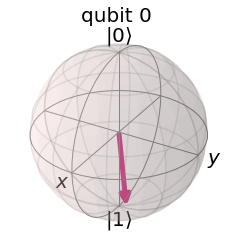

In [35]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

psi0 = Statevector.from_label('0') # Initialize state |0>
params_dict = {p:v for (p,v) in zip(w_param, weights)} # Create a dictionary of Parameter:value
qc_grounded = qc.bind_parameters(params_dict) # Bind parameters to the circuit
new_sv = psi0.evolve(qc_grounded) # Apply the circuit to the initial state

plot_bloch_multivector(new_sv.data)



As you can see the vector is almost pointing in the down direction!